In [1]:
import pandas as pd

In [2]:
# Step 1: read the csv file provided
coursework_csv=pd.read_csv("coursework_1_data_2019.csv")

In [4]:
# Step 2: Derive a new coulmn total_budget_10_year that gives the total spending available to each local authortiy over the specificed decade (2008-2018)
coursework_csv['total_budget_10_year']=coursework_csv['total_budget']*10

In [3]:
# Step 3: Derive a new column media_awareness_10_year that gives the total spending on media awarenss for each local authority over the specified decade (2008-2018)
coursework_csv['media_awareness_10_year']=coursework_csv['media_awareness']*10

In [5]:
# Step 4: Derive a new column media_awareness_proportion that gives you the proportion of spending on media awareness over the specified decade (2008-2018) with respect to the total budget available
coursework_csv['media_awareness_proportion']=coursework_csv['media_awareness_10_year']/coursework_csv['total_budget_10_year']

In [6]:
# Step 5: Derive a new column school_awareness_10_year that gives the total spending on school awarenss for each local authority over the specified decade (2008-2018)
coursework_csv['school_awareness_10_year']=coursework_csv['school_awareness']*10

In [7]:
# Step 6: Derive a new column school_awareness_proportion that gives you the proportion of spending on school awareness over the specified decade (2008-2018) with respect to the total budget available
coursework_csv['school_awareness_proportion']=coursework_csv['school_awareness_10_year']/coursework_csv['total_budget_10_year']

In [8]:
# Step 7: Derive a new column total_case_incidence_2008 which gives you the ratio of the number of childhood obesity cases to the total population in 2008
coursework_csv['total_case_incidence_2008']=coursework_csv['2008_cases_total']/coursework_csv['2008_pop_total']

In [9]:
# Step 8: Derive a new column total_case_incidence 2018 which gives you the ratio of the number of childhood obesity cases to the total population in 2018
coursework_csv['total_case_incidence_2018']=coursework_csv['2018_cases_total']/coursework_csv['2018_pop_total']

In [10]:
# Step 9: Derive a new column difference_total_case_incidence which gives yo the diffrence between the incidence of childhood obesity in 2018 and the incidence of childhood obesity in 2008
coursework_csv['difference_total_case_incidence']=coursework_csv['total_case_incidence_2018']-coursework_csv['total_case_incidence_2008']

In [ ]:
#NOTE:
#Independent variables: school_awareness_proportion and media_awareness_proportion
#Depdendent variables: difference_total_case_incidence

In [14]:
# Step 10: Check multicolinearity between school awareness proportion and media_awareness_proportion (the dependent variables), function borrowed from QM tutrial
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df
new_df=drop_column_using_vif_(coursework_csv[['media_awareness_proportion', 'school_awareness_proportion']])


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
# Step 11: Perform ordinary linear regression using the least squares method
import statsmodels.api as sm
stats = sm.OLS(endog=coursework_csv['difference_total_case_incidence'], exog=sm.add_constant(new_df)).fit()
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     difference_total_case_incidence   R-squared:                       0.144
Model:                                         OLS   Adj. R-squared:                  0.132
Method:                              Least Squares   F-statistic:                     12.53
Date:                             Fri, 12 Nov 2021   Prob (F-statistic):           9.33e-06
Time:                                     16:19:17   Log-Likelihood:                 1056.1
No. Observations:                              152   AIC:                            -2106.
Df Residuals:                                  149   BIC:                            -2097.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0004   7.03e-05      5.028      0.000       0.000       0.000
media_awareness_proportion      0.0012      0.000      3.282      0.001       0.000       0.002
school_awareness_proportion    -0.0006      0.000     -3.155      0.002      -0.001      -0.000
==============================================================================
Omnibus:                        3.870   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.672
Skew:                           0.320   Prob(JB):                        0.159
Kurtosis:                       2.589   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

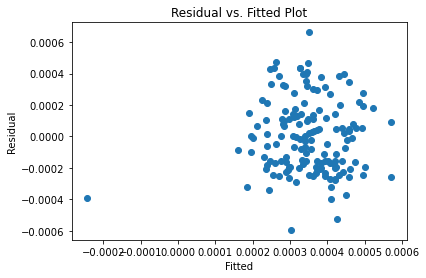

<Figure size 432x288 with 0 Axes>

In [17]:
# Step 12: Assess the viability of linear regression by checking to see if the LINE conditions are satisfied, to do this a residual vs fir plot is drawn
import matplotlib.pyplot as plt
import seaborn as sn
plt.scatter(stats.fittedvalues, stats.resid)
# adding title and labels
plt.xlabel('Fitted')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot')
plt.show()
plt.savefig("RvsF.jpeg")


In [24]:
# Step 0 (extra step to state rationale for research question)
# Determine average percentage of spending on raising school awareness and media awareness across all local authorities
coursework_csv['media_awareness_percentage']=coursework_csv['media_awareness_proportion']*100
coursework_csv['school_awareness_percentage']=coursework_csv['school_awareness_proportion']*100

print(f"The average percentage spending on raising media awareness across all local authorities was = {str(coursework_csv['media_awareness_percentage'].mean())}")

print(f"The average percentage spending on raising school awareness across all local authorities was = {str(coursework_csv['school_awareness_percentage'].mean())}")

The average percentage spending on raising media awareness across all local authorities was = 12.108232468181694
The average percentage spending on raising school awareness across all local authorities was = 24.084616145790253
